In [1]:
from copy import deepcopy
from numpy import array
from numpy.linalg import norm
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Node:
# Un nodo representa un cuerpo si es un nodo final (es decir, si node.child es None)
# o un nodo abstracto del árbol cuádruple si tiene un hijo.

    def __init__(self, m, x, y):
        # El inicializador crea un nodo sin hijos (un cuerpo real).
        self.m = m  #Masa del cuerpo
        
        # En lugar de almacenar la posición de un nodo, almacenamos los tiempos de masa
        # posición, m_pos. Esto facilita la actualización del centro de masa.
        self.m_pos    = m * array([x, y]) 
        self.momentum = array([0., 0.]) 
        
        #Estamos indicando que esto es el nodo final y debemos acomodarlo
        self.child = None

    def into_next_quadrant(self):
    # Coloca el nodo en el cuadrante del siguiente nivel y devuelve el número de cuadrante.
    
        # s: longitud lateral del cuadrante actual
        self.s = 0.5 * self.s  
        
        # Se hace la división en y y en x, para posteriormente obtener el cuadrante
        return self._subdivide(1) + 2*self._subdivide(0) #El 2 nos da conteo de la columna

    def pos(self):
    # Posición física del nodo, independiente del cuadrante actualmente activo.
        return self.m_pos / self.m

    def reset_to_0th_quadrant(self):
    # Reubica el nodo en el cuadrante de nivel 0 (dominio completo).
    
        # La longitud lateral del cuadrante de nivel 0.
        self.s = 1.0  
        
        # La posición relativa dentro del cuadrante es igual a la posición física.
        self.relpos = self.pos().copy()

    def dist(self, other):
    # Distancia entre el nodo actual y otro nodo.
        return norm(other.pos() - self.pos())

    def force_on(self, other):
    # Fuerza que ejerce el nodo actual sobre un cuerpo dado.
    
        ## Esto nos permite hacer correcciónes a distancias cortas
        cutoff_dist = 0.002
        d = self.dist(other)
        if d < cutoff_dist:
            return array([0., 0.]) #No hay fuerza cuando los cuerpos estan muy cerca 
        else:
            # La fuerza gravitatoria va como 1/r**2.
            return (self.pos() - other.pos()) * (self.m*other.m / d**3)

    def _subdivide(self, i):
    # Coloca el nodo en el cuadrante del siguiente nivel a lo largo de la dirección i y vuelve a calcular
    # la posición relativa relpos del nodo dentro de este cuadrante.
        self.relpos[i] *= 2.0
        if self.relpos[i] < 1.0:
            quadrant = 0
        else:
            quadrant = 1
            self.relpos[i] -= 1.0  #Normaliza la posición relativa al restar la longitud del primer cuadrante
        return quadrant

In [4]:
def add(body, node):
    '''Barnes-Hut algorithm: Creación del árbol cuadruple. Esta función añande
       un nuevo cuerpo en el nodo del árbol cuadruple. Devuelve una versión actualizada del nodo.
       body: Objeto de clase nodo
       node: cuadrante del nodo
    '''
# Barnes-Hut algorithm: Creación del árbol cuadruple. Esta función añande 
# un nuevo cuerpo en el nodo del árbol cuadruple. Devuelve una versión actualizada del nodo.

    # 1. Si el nodo n no contiene un cuerpo, coloque el nuevo cuerpo b aquí.
    ## Si node es None, es decir, si tenemos el nodo final, se toma la información de body
    ## En otro caso, se deja una variable tipo NoneType
    new_node = body if node is None else None  
    
    # Para limitar la profundidad de recursión, establezca un límite inferior para el tamaño del cuadrante.
    # Objetos dentro de este cuadrante se consideran iguales
    smallest_quadrant = 1.e-4 ## Cuadrante más pequeño, cambiar a unidades astronomicas
    
    if node is not None and node.s > smallest_quadrant:
        # 3. Si el nodo n es un nodo externo, entonces el nuevo cuerpo b está en conflicto
        # con un cuerpo ya presente en esta región
        if node.child is None: 
            new_node = deepcopy(node)
        # ... Subdividir aún más la región creando cuatro hijos
            new_node.child = [None for i in range(4)] #Creación de una nueva rama del arbol
        # ... Y para empezar, inserte recursivamente el cuerpo ya presente
        # en el cuadrante apropiado.
            quadrant = node.into_next_quadrant() #Esto nos devuelve el cuadrante siguiente
            new_node.child[quadrant] = node
            
        # 2. Si el nodo n es un nodo interno, no debemos modificar su hijo.
        else:
            new_node = node

        # 3. Si el nodo n es o se ha convertido en un nodo interno...
        # ... actualice su masa y "centro de masa por masa".
        new_node.m += body.m
        new_node.m_pos += body.m_pos
        # ... y agrega recursivamente el nuevo cuerpo en el cuadrante apropiado.
        # El proceso de recursividad termina cuando el cuerpo se encuentra en el nodo final
        quadrant = body.into_next_quadrant()
        new_node.child[quadrant] = add(body, new_node.child[quadrant]) 
    return new_node


In [5]:
def force_on(body, node, theta):
    '''Algoritmo de Barnes-Hut: uso del quad-tree. Esta función calcula
       la fuerza neta sobre un cuerpo ejercida por todos los cuerpos en el nodo "nodo".
       Tenga en cuenta cómo el código es más corto y más expresivo que el lenguaje humano
       body: Objeto de clase nodo
       node: cuadrante del nodo
       theta: termino de distancia despreciable
       '''
    #descripción del algoritmo.
    # 1. Si el nodo actual es un nodo externo,
    # calcular la fuerza ejercida por el nodo actual en b.
    if node.child is None:
        return node.force_on(body)

    # 2. De lo contrario, calcula la relación s/d. Si s/d < θ (criterio de distancia),  
    # trate este nodo interno como un solo cuerpo, y calcule la fuerza que ejerce sobre el cuerpo b.
    if node.s < node.dist(body) * theta:
        return node.force_on(body)

    # 3. De lo contrario, ejecute el procedimiento recursivamente en cada hijo.
    return sum(force_on(body, c, theta) for c in node.child if c is not None)


In [6]:
def verlet(bodies, root, theta, G, dt):
    '''Ejecute una iteración de tiempo según el algoritmo de Verlet.
       bodies: Lista de objetos de clase node
       root: cuadrante del arbol
       theta: termino de disntacia despreciable
       G: Constante de gravitación en unidades adecuadas
       dt: paso del algoritmo'''

    for body in bodies:
        force = G * force_on(body, root, theta)
        body.momentum += dt * force
        body.m_pos += dt * body.momentum 


In [7]:
def plot_bodies(bodies, i):
    '''
    Escribe una imagen que represente la posición actual de los cuerpos.
    Para crear una película con avconv o ffmpeg use el siguiente comando:
    ffmpeg -r 15 -i cuerpos_%06d.png -q:v 0 cuerpos.avi 
    bodies: Lista de objetos de clase node
    '''
    ax = plt.gcf().add_subplot(111, aspect='equal')
    ax.cla()
    ax.scatter([b.pos()[0] for b in bodies], [b.pos()[1] for b in bodies], 1)
    ax.set_xlim([0., 1.0])
    ax.set_ylim([0., 1.0])
    plt.show()
    #plt.gcf().savefig('bodies_{0:06}.png'.format(i))

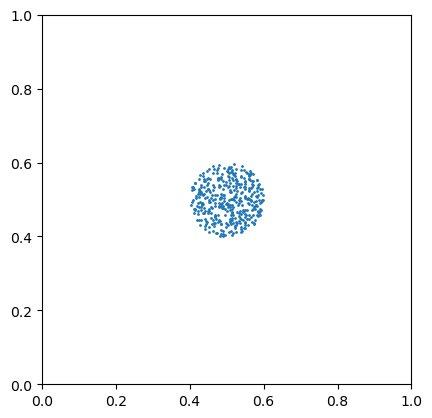

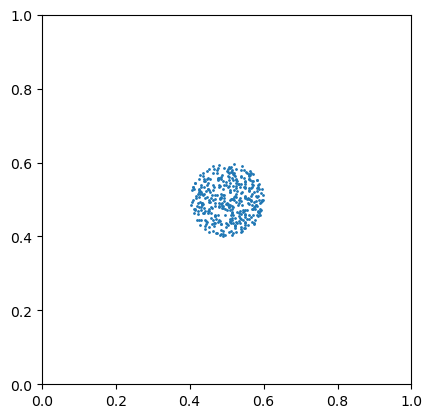

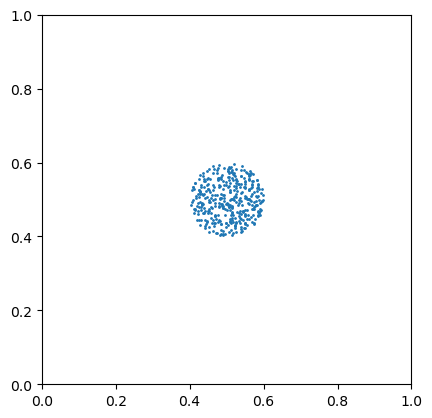

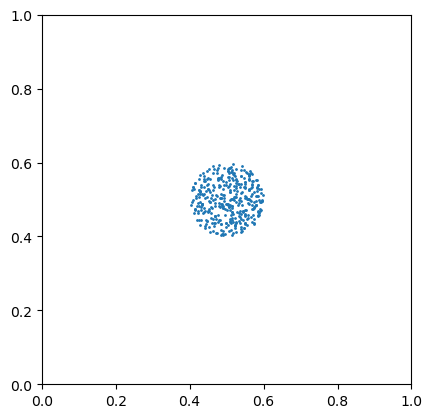

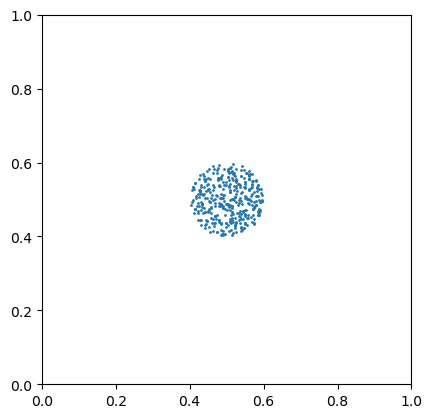

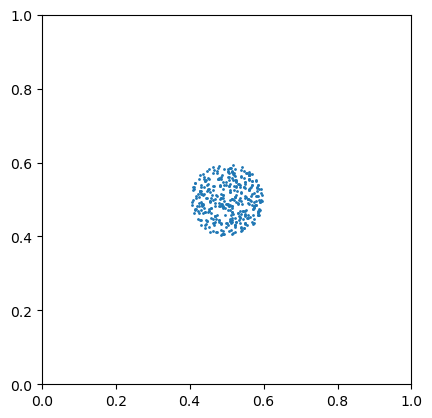

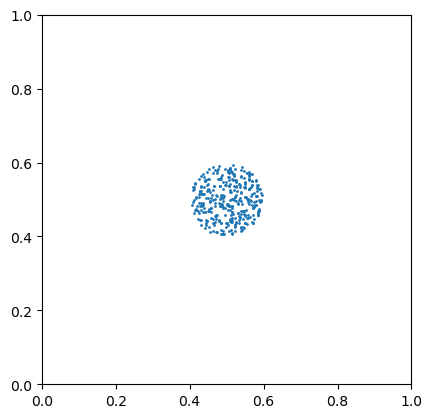

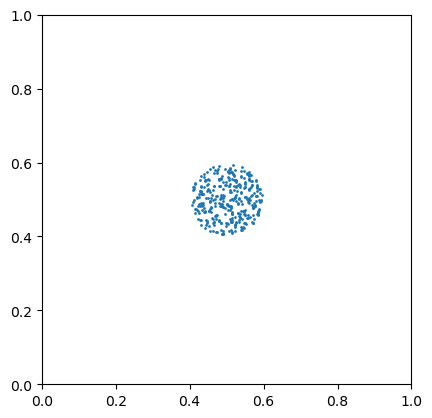

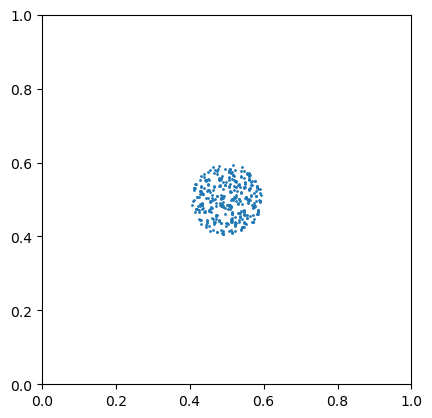

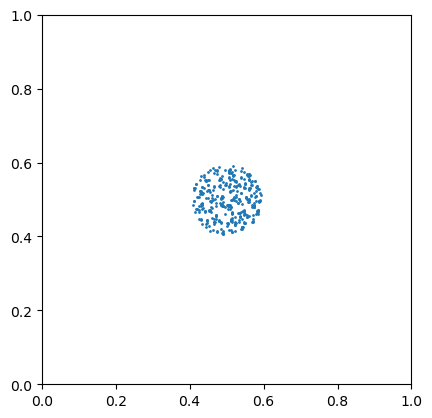

KeyboardInterrupt: 

In [8]:
######### Programa principal ########################################################

# Theta-criterio del algoritmo de Barnes-Hut.
theta = 0.5
# Masa de un cuerpo.
mass = 1.0
# Los cuerpos iniciales se distribuyen en un circulo de radio ini_radius.
ini_radius = 0.1
# Velocidad maxima inicial de los cuerpos
inivel = 0.1
# La "constante gravitatoria" se elige para obtener una salida agradable.
G = 4.e-4
# Paso discreto.
dt = 1.e-4#3
# Número de cuerpos (el número real es menor, porque todos los cuerpos
# fuera del radio inicial se eliminan).
numbodies = 500#1000
# Número de iteraciones de tiempo ejecutadas por el programa.
max_iter = 2000#10000
# Frecuencia con la que se escriben las imágenes PNG.
img_iter = 20

# El generador de números pseudoaleatorios se inicializa en un valor determinista,
# para una validación adecuada de la salida de la serie de ejercicios. semilla.al azar(1)
# x- y y-pos se inicializan en un cuadrado con una longitud de lado de 2*ini_radius.
random.seed(1)
posx = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius
posy = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius
# Solo mantenemos los cuerpos dentro de un círculo de radio ini_radius.
bodies = [ Node(mass, px, py) for (px,py) in zip(posx, posy) \
               if (px-0.5)**2 + (py-0.5)**2 < ini_radius**2 ]


# Inicialmente, los cuerpos tienen una velocidad radial de una amplitud proporcional a
# la distancia desde el centro. Esto induce un movimiento de rotación creando un
# impresión de "galaxia".
for body in bodies:
    r = body.pos() - array([0.5,0.5])
    body.momentum = array([-r[1], r[0]]) * mass*inivel*norm(r)/ini_radius

# Ciclo principal en iteraciones temporales.
for i in range(max_iter):
    # El árbol cuádruple se vuelve a calcular en cada iteración.
    root = None
    for body in bodies:
        body.reset_to_0th_quadrant()
        root = add(body, root)
    # Cómputo de fuerzas, y avance de cuerpos.
    verlet(bodies, root, theta, G, dt)
    # Output
           
    if i%img_iter==0:
        #print("Writing images at iteration {0}".format(i))
        plot_bodies(bodies, i//img_iter)

